# Benchmark model - Pastdue90 - Timewise Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [2]:
#importing data
user=environ["USERNAME"]
prefix = 'time_2018-04-30_p90_'
trainfile = '_traindata'
testfile = '_testdata'
postfix = '_190710_745'
preproc_folder = "benchmarks_time"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix+trainfile+postfix+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix+testfile+postfix+'.pkl') 

In [3]:
y_train.shape

(46101,)

In [4]:
X_train_df = pd.DataFrame(X_train, columns=feature_labels)
X_train_df.head()

,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,cd_trend_a,c_lent_c,c_repaid_c,c_impaired1_c,...,d_pastdue90_c,d_trend_a,d_we_payment_share,invoice_amount,purchase_amount,currency_Britisches Pfund,currency_Euro,currency_Schweizer Franken,currency_US-Dollar,invoice_date
0,-2.159195,0.581487,-0.604370,-0.511071,-0.193,-0.189484,-0.025400,-1.029539,-0.875688,-0.64226,...,-0.191233,-0.009886,0.11441,-0.845852,-2.113662,0.0,0.0,1.0,0.0,-4.071415
1,-2.159195,0.581487,-0.596487,-0.511071,-0.193,-0.189484,-0.025400,-1.028500,-0.875688,-0.64226,...,-0.191233,-0.009886,0.11441,-0.161609,-2.113662,0.0,0.0,1.0,0.0,-4.071415
2,-2.159195,0.581487,-0.588605,-0.511071,-0.193,-0.189484,1.890965,-1.027460,-0.875688,-0.64226,...,-0.191233,1.915140,0.11441,-0.535479,-2.113662,0.0,0.0,1.0,0.0,-4.071415
3,-2.159195,0.581487,-0.604370,-0.511071,-0.193,-0.189484,-0.025400,-1.029539,-0.875688,-0.64226,...,-0.191233,-0.009886,0.11441,0.921730,-2.113662,0.0,0.0,1.0,0.0,-4.071415
4,-2.159195,0.581487,-0.604370,-0.511071,-0.193,-0.189484,-0.025400,-1.028500,-0.875688,-0.64226,...,-0.191233,-0.009886,0.11441,0.390604,-2.113662,0.0,0.0,1.0,0.0,-4.071415


In [5]:
X_train_df.columns

Index(['has_purchase', 'dd_value_date', 'cd_lent_c', 'cd_repaid_c',
       'cd_impaired1_c', 'cd_pastdue90_c', 'cd_trend_a', 'c_lent_c',
       'c_repaid_c', 'c_impaired1_c', 'c_pastdue90_c', 'c_trend_a',
       'cd_lent_c', 'd_repaid_c', 'd_impaired1_c', 'd_pastdue90_c',
       'd_trend_a', 'd_we_payment_share', 'invoice_amount', 'purchase_amount',
       'currency_Britisches Pfund', 'currency_Euro',
       'currency_Schweizer Franken', 'currency_US-Dollar', 'invoice_date'],
      dtype='object')

In [6]:
X_train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
has_purchase,46101.0,2.655000e-09,1.000011,-2.159195,0.463136,0.463136,0.463136,0.463136
dd_value_date,46101.0,2.974673e-09,1.000011,-0.170477,-0.170477,-0.170477,-0.170477,79.964493
cd_lent_c,46101.0,-8.013827e-09,1.000011,-0.604370,-0.557074,-0.446717,0.026240,4.140315
cd_repaid_c,46101.0,-3.949991e-08,1.000011,-0.511071,-0.511071,-0.435532,-0.079420,4.248518
cd_impaired1_c,46101.0,-1.156706e-08,1.000011,-0.193000,-0.193000,-0.193000,-0.193000,7.905553
cd_pastdue90_c,46101.0,-7.045414e-09,1.000011,-0.189484,-0.189484,-0.189484,-0.189484,8.024996
cd_trend_a,46101.0,6.358196e-09,1.000011,-3.777575,-0.693179,-0.025400,0.734599,3.731169
c_lent_c,46101.0,1.025066e-08,1.000011,-1.029539,-0.796781,-0.352049,0.528065,3.092552
c_repaid_c,46101.0,4.257091e-09,1.000011,-0.875688,-0.798560,-0.356937,0.452913,3.499491
c_impaired1_c,46101.0,-2.757867e-08,1.000011,-0.642260,-0.642260,-0.393988,0.226692,4.719173


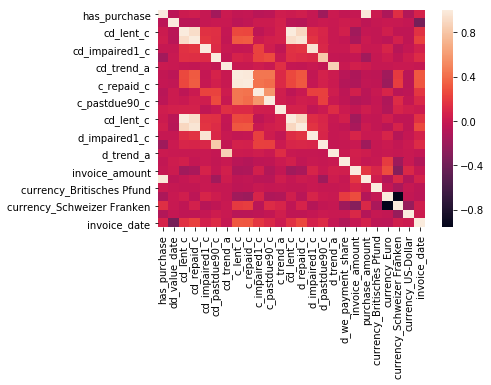

In [7]:
sns.heatmap(X_train_df.corr())

### SGD Classifier

In [8]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf.fit(X_train, y_train)
sgd_clf_diag = model_diag_seq(sgd_clf, X_train, y_train, train_window=12000, test_window=3000)

Preparing fold 0 with start at 4101, 13101 train observations and 3000 test observations...
Fold 0: train  on 13101 from index 0 to 13100, test on 3000 from 13101 to 16100
Preparing fold 1 with start at 7101, 12000 train observations and 3000 test observations...
Fold 1: train  on 12000 from index 4101 to 16100, test on 3000 from 16101 to 19100
Preparing fold 2 with start at 10101, 12000 train observations and 3000 test observations...
Fold 2: train  on 12000 from index 7101 to 19100, test on 3000 from 19101 to 22100
Preparing fold 3 with start at 13101, 12000 train observations and 3000 test observations...
Fold 3: train  on 12000 from index 10101 to 22100, test on 3000 from 22101 to 25100
Preparing fold 4 with start at 16101, 12000 train observations and 3000 test observations...
Fold 4: train  on 12000 from index 13101 to 25100, test on 3000 from 25101 to 28100
Preparing fold 5 with start at 19101, 12000 train observations and 3000 test observations...
Fold 5: train  on 12000 from i

In [9]:
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[10455   841]
 [  132    90]]
Confusion matrix: 
[[0.92555 0.07445]
 [0.01169 0.00797]]
AUC 0.756


In [10]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# max Number of iterations
max_iter = [100, 180, 200, 250, 300, 320, 350] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge', 'perceptron']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window(X_train.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(X_train, y_train)

Preparing fold 0 with start at 4101, 13101 train observations and 3000 test observations...
Preparing fold 1 with start at 7101, 12000 train observations and 3000 test observations...
Preparing fold 2 with start at 10101, 12000 train observations and 3000 test observations...
Preparing fold 3 with start at 13101, 12000 train observations and 3000 test observations...
Preparing fold 4 with start at 16101, 12000 train observations and 3000 test observations...
Preparing fold 5 with start at 19101, 12000 train observations and 3000 test observations...
Preparing fold 6 with start at 22101, 12000 train observations and 3000 test observations...
Preparing fold 7 with start at 25101, 12000 train observations and 3000 test observations...
Preparing fold 8 with start at 28101, 12000 train observations and 3000 test observations...
Preparing fold 9 with start at 31101, 12000 train observations and 3000 test observations...
Preparing fold 10 with start at 34101, 12000 train observations and 3000

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    3.7s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   10.7s
[Parallel(n_jobs=7)]: Done 558 tasks      | elapsed:   30.2s
[Parallel(n_jobs=7)]: Done 841 tasks      | elapsed:   39.8s
[Parallel(n_jobs=7)]: Done 1523 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 2413 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 2759 out of 2772 | elapsed:  1.7min remaining:    0.4s
[Parallel(n_jobs=7)]: Done 2772 out of 2772 | elapsed:  1.7min finished


GridSearchCV(cv=<generator object rolling_window at 0x0000029D34C7F3B8>,
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5...
                                     verbose=0, warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge', 'perceptron'],
                         'max_iter': [100, 180, 200, 250, 300, 320, 3

In [11]:
sgd_gsearch.best_params_

{'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'max_iter': 320}

In [13]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=320, loss='log', learning_rate='constant', eta0=0.01, tol=0.0001) 
sgd_gs.fit(X_train, y_train)
sgd_gs_diag = model_diag_seq(sgd_gs, X_train, y_train,train_window=12000, test_window=3000)

Preparing fold 0 with start at 4101, 13101 train observations and 3000 test observations...
Fold 0: train  on 13101 from index 0 to 13100, test on 3000 from 13101 to 16100
Preparing fold 1 with start at 7101, 12000 train observations and 3000 test observations...
Fold 1: train  on 12000 from index 4101 to 16100, test on 3000 from 16101 to 19100
Preparing fold 2 with start at 10101, 12000 train observations and 3000 test observations...
Fold 2: train  on 12000 from index 7101 to 19100, test on 3000 from 19101 to 22100
Preparing fold 3 with start at 13101, 12000 train observations and 3000 test observations...
Fold 3: train  on 12000 from index 10101 to 22100, test on 3000 from 22101 to 25100
Preparing fold 4 with start at 16101, 12000 train observations and 3000 test observations...
Fold 4: train  on 12000 from index 13101 to 25100, test on 3000 from 25101 to 28100
Preparing fold 5 with start at 19101, 12000 train observations and 3000 test observations...
Fold 5: train  on 12000 from i

In [14]:
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc_gs)

[[10752   544]
 [  134    88]]
Confusion matrix: 
[[0.95184 0.04816]
 [0.01186 0.00779]]
AUC 0.771


### Random Forest Classifier

In [15]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=7)

rf_clf.fit(X_train, y_train)
rf_clf_diag = model_diag_seq(rf_clf, X_train, y_train,train_window=12000, test_window=3000)

Preparing fold 0 with start at 4101, 13101 train observations and 3000 test observations...
Fold 0: train  on 13101 from index 0 to 13100, test on 3000 from 13101 to 16100
Preparing fold 1 with start at 7101, 12000 train observations and 3000 test observations...
Fold 1: train  on 12000 from index 4101 to 16100, test on 3000 from 16101 to 19100
Preparing fold 2 with start at 10101, 12000 train observations and 3000 test observations...
Fold 2: train  on 12000 from index 7101 to 19100, test on 3000 from 19101 to 22100
Preparing fold 3 with start at 13101, 12000 train observations and 3000 test observations...
Fold 3: train  on 12000 from index 10101 to 22100, test on 3000 from 22101 to 25100
Preparing fold 4 with start at 16101, 12000 train observations and 3000 test observations...
Fold 4: train  on 12000 from index 13101 to 25100, test on 3000 from 25101 to 28100
Preparing fold 5 with start at 19101, 12000 train observations and 3000 test observations...
Fold 5: train  on 12000 from i

In [16]:
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - seq_valid','RF - test'])
show(rf_test_auc)

[[9865 1431]
 [ 104  118]]
Confusion matrix: 
[[0.87332 0.12668]
 [0.00921 0.01045]]
AUC 0.821


### Randomized Grid Search

In [17]:
# Number of trees in random forest
n_estimators = [150, 180, 200, 250, 280, 300, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 10, 20]
# Maximum number of levels in tree
max_depth = [100,200, None]
#Max leaf nodes
max_leaf_nodes = [10,20,40,60]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [18]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, 
                               cv = rolling_window(X_train.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True), 
                               verbose=2, random_state=42, n_jobs =7, refit='AUC')
# Fit the random search model
rf_random.fit(X_train, y_train)

Preparing fold 0 with start at 4101, 13101 train observations and 3000 test observations...
Preparing fold 1 with start at 7101, 12000 train observations and 3000 test observations...
Preparing fold 2 with start at 10101, 12000 train observations and 3000 test observations...
Preparing fold 3 with start at 13101, 12000 train observations and 3000 test observations...
Preparing fold 4 with start at 16101, 12000 train observations and 3000 test observations...
Preparing fold 5 with start at 19101, 12000 train observations and 3000 test observations...
Preparing fold 6 with start at 22101, 12000 train observations and 3000 test observations...
Preparing fold 7 with start at 25101, 12000 train observations and 3000 test observations...
Preparing fold 8 with start at 28101, 12000 train observations and 3000 test observations...
Preparing fold 9 with start at 31101, 12000 train observations and 3000 test observations...
Preparing fold 10 with start at 34101, 12000 train observations and 3000

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   32.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  2.6min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:  6.3min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed: 10.8min
[Parallel(n_jobs=7)]: Done 880 out of 880 | elapsed: 16.5min finished


RandomizedSearchCV(cv=<generator object rolling_window at 0x0000029D36F150A0>,
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fracti...
                   iid='warn', n_iter=80, n_jobs=7,
                   p

In [19]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 60,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [20]:
# Number of trees in random forest
n_estimators = [220, 250, 300] 
# Number of features to consider at every split
max_features = ['sqrt', 5]
# Maximum number of levels in tree
max_depth = [None]
#Max leaf nodes
max_leaf_nodes = [60,80]
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [21]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window(X_train.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(X_train, y_train)

Preparing fold 0 with start at 4101, 13101 train observations and 3000 test observations...
Preparing fold 1 with start at 7101, 12000 train observations and 3000 test observations...
Preparing fold 2 with start at 10101, 12000 train observations and 3000 test observations...
Preparing fold 3 with start at 13101, 12000 train observations and 3000 test observations...
Preparing fold 4 with start at 16101, 12000 train observations and 3000 test observations...
Preparing fold 5 with start at 19101, 12000 train observations and 3000 test observations...
Preparing fold 6 with start at 22101, 12000 train observations and 3000 test observations...
Preparing fold 7 with start at 25101, 12000 train observations and 3000 test observations...
Preparing fold 8 with start at 28101, 12000 train observations and 3000 test observations...
Preparing fold 9 with start at 31101, 12000 train observations and 3000 test observations...
Preparing fold 10 with start at 34101, 12000 train observations and 3000

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   19.5s
[Parallel(n_jobs=7)]: Done 132 out of 132 | elapsed:  1.5min finished


GridSearchCV(cv=<generator object rolling_window at 0x0000029D36F15048>,
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_lea...
                                              warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'bootstrap': [True], 'max_depth': [None],
                         'max_features': ['sqrt', 5],
               

In [22]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 80,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

In [23]:
#optimized params 
rf_opt = {'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 80,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [24]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)
rf_opt_clf.fit(X_train, y_train)
rf_opt_diag = model_diag_seq(rf_opt_clf, X_train, y_train, train_window=12000, test_window=3000)

Preparing fold 0 with start at 4101, 13101 train observations and 3000 test observations...
Fold 0: train  on 13101 from index 0 to 13100, test on 3000 from 13101 to 16100
Preparing fold 1 with start at 7101, 12000 train observations and 3000 test observations...
Fold 1: train  on 12000 from index 4101 to 16100, test on 3000 from 16101 to 19100
Preparing fold 2 with start at 10101, 12000 train observations and 3000 test observations...
Fold 2: train  on 12000 from index 7101 to 19100, test on 3000 from 19101 to 22100
Preparing fold 3 with start at 13101, 12000 train observations and 3000 test observations...
Fold 3: train  on 12000 from index 10101 to 22100, test on 3000 from 22101 to 25100
Preparing fold 4 with start at 16101, 12000 train observations and 3000 test observations...
Fold 4: train  on 12000 from index 13101 to 25100, test on 3000 from 25101 to 28100
Preparing fold 5 with start at 19101, 12000 train observations and 3000 test observations...
Fold 5: train  on 12000 from i

In [25]:
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[10982   314]
 [  152    70]]
Confusion matrix: 
[[0.9722  0.0278 ]
 [0.01346 0.0062 ]]
AUC 0.794
